## Predicting Burst Pressure with Tensorflow and Global Data

Developing  model for Burst pressure by optimizing parameter in the Origional Model of Netto et al. (2005). The model to develop has the form of:

\begin{align}
\mathbf{P} = {f_{red}}{P_{intact}}= (1-k_1\frac{d}{t}^{k_2}\frac{l}{D}^{k_3})\frac{2tUTS}{D} 
\end{align}

Where:<br>
$f_{red}$: Reduction factor;<br>
$P_{intact}$: Burst pressure of the intact pipe (MPa);<br>
t: wall thickness (mm);<br>
D: Diameter (mm);<br>
UTS (or xicma u): Ultimate tensile strength (mm) ;<br>
d: defect depth (mm);<br>
k1, k2, k3: Need-to-optimize parameters. 


Author (Phan et al., 2017) has developed burst pressure model from format of Netto et al. (2005) and Differential Evolution optimization algorithm with the following results:

\begin{align}
\mathbf{P} = (1-0.88555\frac{d}{t}^{0.98077}\frac{l}{D}^{0.31053})\frac{2tUTS}{D} 
\end{align}

In this notebook, author develops the burst pressure model based on a global database and the Gradient Descent Optimization algorithm. Databased used to develop models for high strength steel, collected from Ma et al. (2013) (79 samples), Shuai et al. (2017) (53 samples), Phan et al. (2017) (28 samples), Freire et al. (2006) (17 samples), Cronin (2000) (40 samples) with total of 217 samples. Tensorflow framework is used with various libraries listed in the folowing codes.

References:<br>
- Cronin, D.S., 2000. Assessment of corrosion defects in pipelines. Doctor of philosophy dissertation, University of Waterloo.
- Freire, J.L.F., Vieira, R.D., Castro, J.T.P. and Benjamin, A.C., 2006. Part 3: Burst tests of pipeline with extensive longitudinal metal loss. Experimental Techniques, 30(6), pp.60-65.
- Ma, B., Shuai, J., Liu, D. and Xu, K., 2013. Assessment on failure pressure of high strength pipeline with corrosion defects. Engineering Failure Analysis, 32, pp.209-219.
- Netto, T.A., Ferraz, U.S., and Estefen, S.F. 2005. The effect of corrosion defects on the burst pressure of pipelines. Journal of Constructional Steel Research, 61(8): 1185–1204. doi:10.1016/j.jcsr.2005.02.010.
- Phan, H.C., Dhar, A.S. and Mondal, B.C., 2017. Revisiting burst pressure models for corroded pipelines. Canadian Journal of Civil Engineering, 44(7), pp.485-494.
- Shuai, Y., Shuai, J. and Xu, K., 2017. Probabilistic analysis of corroded pipelines based on a new failure pressure model. Engineering failure analysis, 81, pp.216-233.

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf

C:\Users\phanc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set up working directory
os.chdir(r'C:\Hieu 2019\After grad\the 7th paper')
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : C:\Hieu 2019\After grad\the 7th paper


In [3]:
# Importing the dataset
file_name='data1.csv'
dataset = pd.read_csv(file_name)
dataset.head()

,Unnamed: 0,Grade,D,t,d,L,xicma u,P test,Po,Ratio,file,Cummulative
0,1,X42,273.30,4.95,3.30,182.88,453.86,7.20,16.440593,0.437940,2,1
1,2,X42,272.97,4.67,2.62,48.26,453.86,11.80,15.529371,0.759850,2,2
2,3,X42,273.53,4.78,1.63,30.48,453.86,14.56,15.862617,0.917881,2,3
3,4,X42,273.10,4.88,2.18,101.60,453.86,11.69,16.219969,0.720717,2,4
4,5,X42,273.89,4.93,1.60,45.72,453.86,14.63,16.338894,0.895409,2,5


In [4]:
# Setup input variable and dependance variable
X = dataset.iloc[:, 2:7].values
y = dataset.iloc[:,7].values

In [5]:
# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# # sc_y = StandardScaler()
# X = sc_X.fit_transform(X)
# # y = sc_y.fit_transform(y.reshape(-1, 1))

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
class netto_et_al(object):
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## build the model
        with self.g.as_default():
            ## set graph-level random-seed
            tf.set_random_seed(random_seed)
            
            self.build()
            ## create initializer
            self.init_op = tf.global_variables_initializer()
        
    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, None), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None,), name='y_input')
        print(self.X)
        print(self.y)
        ## define weight matrix and bias vector
        self.k1 = tf.Variable(tf.ones(shape=(1)), name='weight')
        self.k2 = tf.Variable(tf.ones(shape=(1)), name='weight')
        self.k3 = tf.Variable(tf.ones(shape=(1)), name='weight')
        print(self.k1,self.k2,self.k3)

        self.y_pred = tf.squeeze(2*self.X[:,1]*self.X[:,4]/self.X[:,0]*(1-self.k1*(self.X[:,2]/self.X[:,1])**self.k2*(self.X[:,3]/self.X[:,0])**self.k3), name='y_pred')
        print(self.y_pred)
        
        sqr_errors = tf.square(self.y - self.y_pred, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
#         self.sum_cost = tf.reduce_sum(sqr_errors, name='mean_cost')
#         tf.reduce_sum(x, 1)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate, name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [7]:
model1 = netto_et_al(x_dim=X_train.shape[0], learning_rate=0.00001)

Tensor("x_input:0", shape=(?, ?), dtype=float32)
Tensor("y_input:0", shape=(?,), dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref> <tf.Variable 'weight_1:0' shape=(1,) dtype=float32_ref> <tf.Variable 'weight_2:0' shape=(1,) dtype=float32_ref>
Tensor("y_pred:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [8]:
def train_model1(sess, model, X_train, y_train, num_epochs=100):
    ## initialiaze all variables: 
    sess.run(model.init_op)    
    training_costs = [] 
    parameters = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
        k11,k22,k33 = sess.run([model.k1, model.k2,model.k3], feed_dict={model.X:X_train, model.y:y_train})
        parameters.append([np.asscalar(k11),np.asscalar(k22),np.asscalar(k33)])       
    return training_costs,parameters

In [9]:
sess = tf.Session(graph=model1.g) 
training_costs,parameters = train_model1(sess, model1, X_train, y_train, num_epochs=10000)

In [10]:
## Print all results
# for i,j in zip(parameters,training_costs):
#     print(i,j)

## Print final results
final_paramters=parameters[-1]
final_cost=training_costs[-1]
print('Parameters [k1, k2, k3]: ',final_paramters)
print('Mean Square Error: ',final_cost)

Parameters [k1, k2, k3]:  [0.8776366710662842, 1.1740978956222534, 0.3116709291934967]
Mean Square Error:  2.2965822


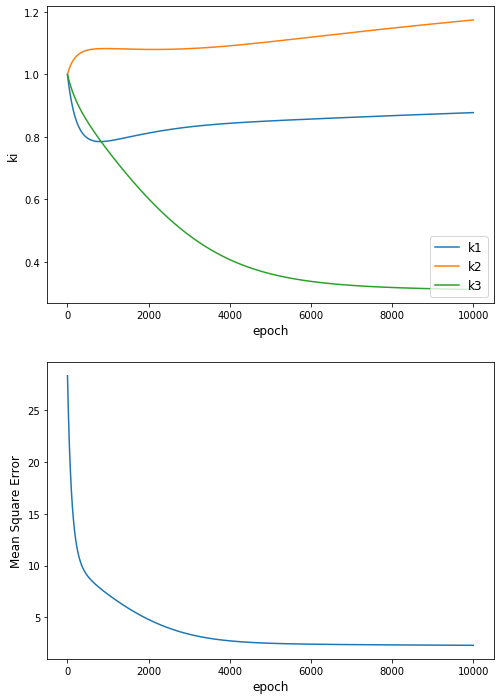

In [11]:
# Visualising results
fig, ax = plt.subplots(figsize=(8,12))
plt.subplot(211)
plt.plot(np.asarray(parameters)[:,0],label="k1")
plt.plot(np.asarray(parameters)[:,1],label="k2")
plt.plot(np.asarray(parameters)[:,2],label="k3")
plt.legend(loc='lower right',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.ylabel('ki',fontsize=12)

plt.subplot(212)
plt.plot(training_costs)
plt.xlabel('epoch',fontsize=12)
plt.ylabel('Mean Square Error',fontsize=12)
plt.show()

In [12]:
def predict(X,k1,k2,k3):
    return 2*X[:,1]*X[:,4]/X[:,0]*(1-k1*(X[:,2]/X[:,1])**k2*(X[:,3]/X[:,0])**k3)

In [13]:
# Model evaluation
y_test_pred=predict(X_test,final_paramters[0],final_paramters[1],final_paramters[2])
y_train_pred=predict(X_train,final_paramters[0],final_paramters[1],final_paramters[2])
from sklearn.metrics import mean_squared_error,r2_score

MSE=mean_squared_error(y_test,y_test_pred)
R2=r2_score(y_test,y_test_pred)
print('Mean Squared Error (Test data): ',MSE)
print('R square (Test data): ',R2)

Mean Squared Error (Test data):  3.4092006244813438
R square (Test data):  0.9356286300437289


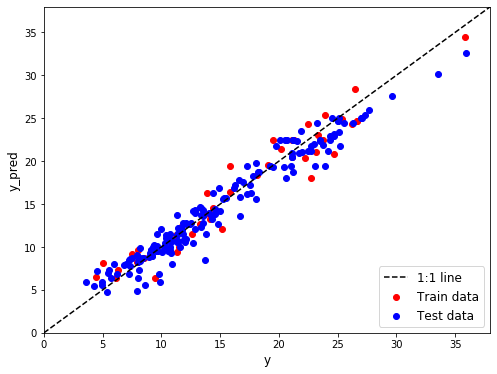

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y_test,y_test_pred,color='r',label="Train data")
plt.scatter(y_train,y_train_pred,color='b',label="Test data")

xy_line = (0, round(max(y_test)+2))
ax.plot(xy_line,xy_line,'k--', label='1:1 line')
plt.xlabel('y',fontsize=12)
plt.ylabel('y_pred',fontsize=12)
plt.xlim( xy_line )
plt.ylim( xy_line )
plt.legend(loc='lower right',fontsize=12)
plt.show()